# NOTE: We have never actually learned how to get a Neural Network to predict FUTURE prices. I can't find anything on the subject (except for one day out).


# We might have to drop that part.

# Jeff you were right! "If it were that easy, wouldn't everyone be doing it". Sorry senpai:)

# Imports

# 1. Preprocess
* Get data from an API
* Filter out the data we don't need

* Scale the data
* Set up a train test split on the data

In [104]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas as hvplot
sns.set_style('darkgrid')

In [105]:
ticker = 'GOOGL'
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
df = yf.download(ticker, 
            period = '2y', # A period of 2 years from today
            prepost = True, # Pre and Post markets included
            threads = True # Multi-thread processing for faster output.
           )
df # This data already looks like it is based of business days.
# Rearranging the columns to help with the Heatmap
df = df[['Close','Open','High','Low','Volume']]
df

[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,Volume
Date,,,,,
2019-04-15,1226.530029,1224.089966,1229.300049,1214.560059,1189800
2019-04-16,1231.910034,1230.000000,1235.979980,1225.040039,1131100
2019-04-17,1240.140015,1237.000000,1245.099976,1232.900024,1518300
2019-04-18,1241.469971,1245.000000,1245.939941,1239.410034,1237500
2019-04-22,1253.760010,1236.670044,1254.339966,1233.369995,954200
...,...,...,...,...,...
2021-04-06,2209.260010,2210.919922,2228.000000,2201.790039,1762000
2021-04-07,2239.030029,2213.100098,2244.500000,2213.100098,1206700
2021-04-08,2250.429932,2264.000000,2271.790039,2243.010010,1433200


In [106]:
# Optional
#df = df.Close

### Changing the absolute values to percents

In [107]:
close_price_change = df.pct_change()

### Seeing which columns actually correlate.
Low correlation does not help the model.
Does high correlation actually do better?

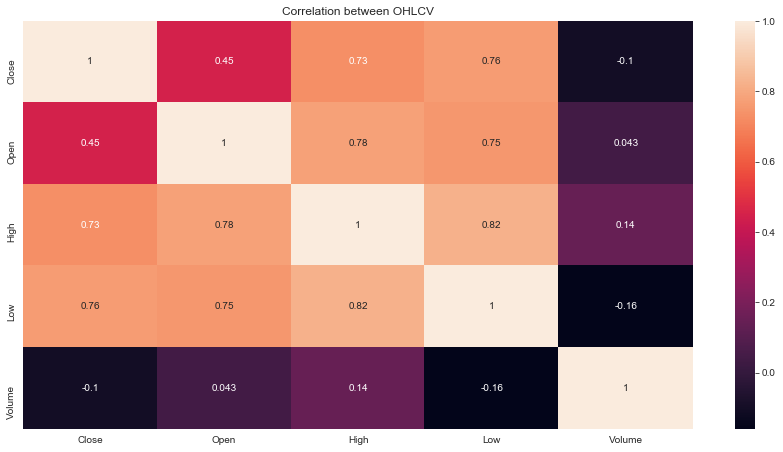

In [108]:
# sns.set_style("darkgrid")
correlation = close_price_change.corr()

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Correlation between OHLCV')
heat_map = sns.heatmap(data = correlation,
#                        x = correlation.Close,
                       annot=True,
                      ax = ax)
heat_map

## This is to help us easily see which columns have low correlation to Close
### So if you were to decide to put other data in the main dataframe, this would hopefully filter that out if it wasn't useful

In [109]:
print('Correlations')
correlations = pd.DataFrame([correlation[x] for x in correlation][0])
print(correlations)

# Automatically keeping the high correlations
keepers = correlations[correlations.Close> 0.6]
keeper_columns = list(keepers.index)
print('\n\nHigh Correlations')
keeper_columns

Correlations
           Close
Close   1.000000
Open    0.449007
High    0.732242
Low     0.764539
Volume -0.102228


High Correlations


['Close', 'High', 'Low']

### I would say to only keep High and Low

In [110]:
df = df.loc[:,keeper_columns]
df = df[['Low','High','Close']]
df

,Low,High,Close
Date,,,
2019-04-15,1214.560059,1229.300049,1226.530029
2019-04-16,1225.040039,1235.979980,1231.910034
2019-04-17,1232.900024,1245.099976,1240.140015
2019-04-18,1239.410034,1245.939941,1241.469971
2019-04-22,1233.369995,1254.339966,1253.760010
...,...,...,...
2021-04-06,2201.790039,2228.000000,2209.260010
2021-04-07,2213.100098,2244.500000,2239.030029
2021-04-08,2243.010010,2271.790039,2250.429932


### Separating the data into X and y

# THE PROBLEM WITH THIS MODEL
## It doesn't predict into the actual future. It only predicts things that have already happened. 
Pretty lame. I will try to get it to predict future values.

In [111]:
# Using this piece of information doesn't seem to do anything really.
# You could skip this and the next cell and it would work just as good.
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [112]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 2 # Close
target_column = 2
X, y = window_data(df, window_size, feature_column, target_column)

In [113]:
# IF you get rid of the two cells above and use this one, it might just work.
# X = df[['High','Low']].values
# y = df.Close.values.reshape(-1,1)

In [114]:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Standardizing the data

In [115]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [116]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [118]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [119]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [120]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 20)            1760      
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 20)            3280      
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [121]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=0)

In [73]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 3ms/step - loss: 0.0022 - mse: 0.0022    


[0.0022075618617236614, 0.0022075618617236614]

In [ ]:
model.history['mean_squared_error']
# plt.plot(model.history['mse'])
# plt.title('model mse')
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [86]:
predicted = model.predict(X_test)

In [75]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [101]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel()})
#     "Predicted": predicted_prices.ravel()
#     }, index = df.index[-len(real_prices): ]

stocks.tail()

,Real
94,2218.959961
95,2209.260010
96,2239.030029
97,2250.429932
98,2270.669922


In [102]:
stocks.hvplot(title = "Using Actual Prices as the Features - 80 Epochs", figsize = (15, 7.5))

:Curve   [index]   (Real)

# 2. Trading Strategies

* Create a strategy that does well in BULL markets.
* Create a strategy that does well in BEAR markets.
* Figure out how much would be made with a buy and hold strategy
* Create a cumulative returns graph to display the difference

# 3. Combining Trading Strategies

* Combine the strategies
* Figure out a trigger that allows the model to switch between strategies.
* Backtest the combined strategy
* Compare the cumulative returns of the buy and hold vs this strategy.

# 4. Predictive Model
* Create a model that can predict future prices.
* Check to see if the model is over or underfit.
* Apply the combined strategy with the predicted values
* Backtest /forward test.
* Compare using a cumulative returns graph.

# 5. Conclusions
* How did our model do compared to a buy and hold strategy?
    * Buy how much did or didn't it suck.
    * Cumulative returns
    * Risk
    * Number of trades
    * Number of gains / (Number of gains + Number of losses)
    * ## Anything else you guys think would help in the comparison.